#**Wine Types Analysis Using Deep Learning Exercise Solution**

We will now focus on our main objectives of building predictive models to predict the wine types (red or white wine) based on other features using Deep Learning. 

Adapted from Dipanjan Sarkar et al. 2018. [Practical Machine Learning with Python](https://link.springer.com/book/10.1007/978-1-4842-3207-1).

In [ ]:
# Import necessary dependencies
# We wil use matplotlib and seaborn for exploratory data analysis and visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

#Download Wine Quality Datasets

In [ ]:
!pip install wget
!python -m wget -o winequality-red.csv "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
!python -m wget -o winequality-white.csv "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
!python -m wget -o winequality.names "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names"

--2022-05-19 16:52:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.1s    

2022-05-19 16:52:27 (637 KB/s) - ‘winequality-red.csv’ saved [84199/84199]

--2022-05-19 16:52:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[======

# Load and merge datasets

In [ ]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# store wine type as an attribute
red_wine['wine_type'] = 'red'   
white_wine['wine_type'] = 'white'
# bucket wine quality scores into qualitative quality labels
# Wine quality scores of 3, 4, and 5 are mapped to low quality,
# 6 and 7 are mapped to medium quality, 8 and 9 are mapped to high quality 
# wines under the quality_label attribute. 
red_wine['quality_label'] = red_wine['quality'].apply(lambda value: 'low' 
                                                          if value <= 5 else 'medium' 
                                                              if value <= 7 else 'high')
red_wine['quality_label'] = pd.Categorical(red_wine['quality_label'], 
                                           categories=['low', 'medium', 'high'])
white_wine['quality_label'] = white_wine['quality'].apply(lambda value: 'low' 
                                                              if value <= 5 else 'medium' 
                                                                  if value <= 7 else 'high')
white_wine['quality_label'] = pd.Categorical(white_wine['quality_label'], 
                                             categories=['low', 'medium', 'high'])

# merge red and white wine datasets
wines = pd.concat([red_wine, white_wine])
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

# Understand dataset features and values

In [ ]:
print(white_wine.shape, red_wine.shape)
print(wines.info())

(4898, 14) (1599, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         6497 non-null   float64 
 1   volatile acidity      6497 non-null   float64 
 2   citric acid           6497 non-null   float64 
 3   residual sugar        6497 non-null   float64 
 4   chlorides             6497 non-null   float64 
 5   free sulfur dioxide   6497 non-null   float64 
 6   total sulfur dioxide  6497 non-null   float64 
 7   density               6497 non-null   float64 
 8   pH                    6497 non-null   float64 
 9   sulphates             6497 non-null   float64 
 10  alcohol               6497 non-null   float64 
 11  quality               6497 non-null   int64   
 12  wine_type             6497 non-null   object  
 13  quality_label         6497 non-null   category
dtypes: category(1), float64(11), int64

We have 4898 white wine data points and 1599 red wine data points. The
merged dataset contains a total of 6497 data points and we also get an idea of numeric and categorical
attributes.

In [ ]:
# Let’s take a peek at our dataset to see some sample data points.
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,white,high
1,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,red,low
2,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,white,medium
3,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,white,medium
4,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,white,medium


#Utilty functions for model evaluation

In [ ]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]
    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 

def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


#Predicting Wine Types

We will predict the wine type based on other features. To start with, we
will first select our necessary features and separate out the prediction class labels and prepare train and test
datasets. We use the prefix **wtp_** in our variables to easily identify them as needed, where **wtp** depicts wine
type prediction.

In [ ]:
wtp_features = wines.iloc[:,:-3]
wtp_feature_names = wtp_features.columns
wtp_class_labels = np.array(wines['wine_type'])

# prepare train and test datasets
wtp_train_X, wtp_test_X, wtp_train_y, wtp_test_y = train_test_split(wtp_features, wtp_class_labels, 
                                                                    test_size=0.2, random_state=42)

print(Counter(wtp_train_y), Counter(wtp_test_y))
print('Features:', list(wtp_feature_names))

Counter({'white': 3418, 'red': 1129}) Counter({'white': 1480, 'red': 470})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


The numbers show us the wine samples for each class and we can also see the feature names which will
be used in our feature set.

##Feature Scaling

We will be using a standard scaler in this
scenario.

In [ ]:
# Define the scaler 
wtp_ss = StandardScaler().fit(wtp_train_X)

# Scale the train set
wtp_train_SX = wtp_ss.transform(wtp_train_X)

# Scale the test set
wtp_test_SX = wtp_ss.transform(wtp_test_X)

##Train a Model using Deep Learning (MLP)

Let’s try
modeling the data using a fully connected deep neural network (DNN) with three hidden layers.

###Encodes wine type class labels

In [ ]:
le = LabelEncoder()
le.fit(wtp_train_y)
# encode wine type labels
wtp_train_ey = le.transform(wtp_train_y)
wtp_test_ey = le.transform(wtp_test_y)

###Build & Compile DNN Model Architecture
Let’s build the architecture for our three-hidden layer DNN where each hidden layer has 16 units (the
input layer has 11 units for the 11 features) and the output layer has 1 unit to predict a 0 or 1, which maps
back to red or white wine. 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Build a sequential model of three-hidden layer DNN where each hidden layer has 16 units and 'relu' activation
# (the input layer has 11 units for the 11 features) and the output layer has 1 unit and 'sigmoid' activation
wtp_dnn_model = Sequential()
wtp_dnn_model.add(Dense(16, activation='relu', input_shape=(11,)))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(1, activation='sigmoid'))

# Configures the model for training use 'Adam' as optimizer, 'binary_crossentropy' 
# as loss funciton, and 'accuracy' as evaluation metrics
wtp_dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

###Train the Model
We use 10% of the training data for a validation set while training the model to see how it performs at
each epoch

In [ ]:
history = wtp_dnn_model.fit(wtp_train_SX, wtp_train_ey, epochs=10, batch_size=5, 
                            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
819/819 [==============================] - 6s 6ms/step - loss: 0.1165 - accuracy: 0.9677 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 2/10
819/819 [==============================] - 4s 5ms/step - loss: 0.0287 - accuracy: 0.9951 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 0.0223 - accuracy: 0.9963 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 0.0164 - accuracy: 0.9973 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/10
819/819 [==============================] - 3s 4ms/step - loss: 0.0147 - accuracy: 0.9973 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/10
819/819 [==============================] - 3s 3ms/step - loss: 0.0125 - accuracy: 0.9971 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 

###Predict on test data
Let’s now predict and evaluate our model on the actual test dataset.

In [ ]:
wtp_dnn_ypred = wtp_dnn_model.predict(wtp_test_SX)
wtp_dnn_ypred = np.round(wtp_dnn_ypred).astype(int)
wtp_dnn_predictions = le.inverse_transform(np.ravel(wtp_dnn_ypred)) # make 1d array

###Evaluate Model Performance

In [ ]:
display_model_performance_metrics(true_labels=wtp_test_y,predicted_labels=wtp_dnn_predictions, classes=['red', 'white'])

Model Performance metrics:
------------------------------
Accuracy: 0.9938
Precision: 0.9938
Recall: 0.9938
F1 Score: 0.9938

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         red       0.99      0.98      0.99       470
       white       0.99      1.00      1.00      1480

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     red white
Actual: red          461     9
        white          3  1477


We get an overall F1 Score and model accuracy of 99.5%, which is even
better than our previous model! This goes to prove you don’t always need big data but good quality data
and features even for Deep Learning models.

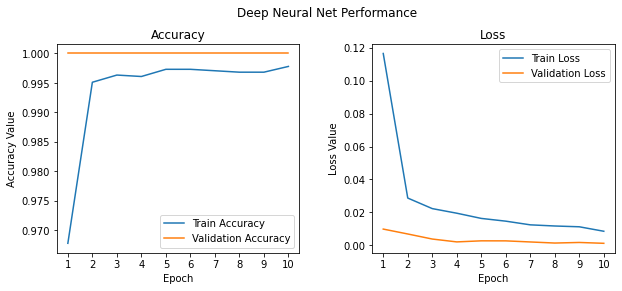

In [ ]:
# Plot the loss and accurcy measures at each epoch
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,11))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")